In [1]:
import os
import pickle
import numpy as np
from collections import Counter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def rougeScores(genSummary, refSummary):
    genTotal, refTotal, intersection = 0., 0., 0.
    for token in list(set(list(refSummary.keys()) + list(genSummary.keys()) )):
        intersection += min(refSummary[token], genSummary[token])
        refTotal += refSummary[token]
        genTotal += genSummary[token]

    recall = intersection / refTotal if refTotal > 0. else 0.
    prec   = intersection / genTotal if genTotal > 0. else 0.
    f1 = (2. * recall * prec) / (recall + prec) if (recall + prec) > 0. else 0.
    
    return recall, prec, f1

In [3]:
class lstmRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, input_size, outputsize, nunits, nlayers, sent_size, batch_size):        
        super(lstmRegressor, self).__init__()
        self.nunits = nunits
        self.nlayers = nlayers
        self.sent_size = sent_size
        self.batch_size = batch_size
        
        self.hidden = self.init_hidden()

        self.lstmlayer = nn.LSTM(nunits, nunits, num_layers=self.nlayers)        
        self.linearlayer= nn.Linear(nunits, nunits)
        
        self.dense1_bn = nn.BatchNorm1d(nunits * 2)
        
        self.outputlayer = nn.Linear(nunits * 2, outputsize)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(self.sent_size, self.batch_size, self.nunits)),
                autograd.Variable(torch.zeros(self.sent_size, self.batch_size, self.nunits)))
    
    def forward(self, sent_embed, summ_embed):
        hiddenlayer0 = self.linearlayer(sent_embed)
        
        out, hiddenlayer = self.lstmlayer(summ_embed, self.hidden)
        hiddenlayer1 = self.linearlayer(out[-1])
        # Concatenates the layers into (600, 2)
        catlayer = torch.cat((hiddenlayer0, hiddenlayer1), 1)
        
        return self.outputlayer(self.dense1_bn(catlayer))

def buildPredSummary(df, summary, sentence_emb, curr_pred_emb, action, select_index, sent_index):
    if action.select(1, select_index).tolist()[0] == 1:
        sum_len =  curr_pred_emb.size()[0] - 1
        newsummary = curr_summary + ' ' + df['sentence'][sent_index]
        curr_pred_emb = torch.cat([curr_pred_emb[0:sum_len, :], sentence_emb], 0)
        return curr_pred_emb, newsummary
    
    else:
        return curr_pred_emb, curr_summary

In [4]:
sdf = pd.read_csv('/home/francisco/GitHub/DQN-Event-Summarization/data/sif/train_000_0.csv')

# Initializing stuff

SKIP = 0
SELECT = 1

true_summary = sdf['summary'][0]
ts_tokenized = Counter(true_summary.split(" "))

nepochs = 500
lrate = 0.01
momentum_rate = 0.8

outputdim = 2
batchsize = 1
sent_size = 1
sif_emb_d = 300
nhiddenlayers = 1
predsummary_size = 10

rand_rate = 1.0
decay_rate = 0.05

criterion = nn.MSELoss()
nsentences = sdf.index.max()

In [5]:
model = lstmRegressor(sent_size, outputdim, sif_emb_d, nhiddenlayers, predsummary_size, batchsize)
model.zero_grad()

# swap to ADAM
optimizer = optim.Adam(model.parameters(), lr=lrate)

lossf = {'loss': [], 'sent_idx': [], 'epoch': [], 'action': [], 'f1': [], 'optpred': [], 'rouge_delta':[]}
for epoch in range(nepochs):
    # reset embeddings and summary at the start of training
    f1_t0 = 0.
    curr_summary = ''
    predsummary_emb = torch.from_numpy(np.zeros((predsummary_size, sif_emb_d))).float()
    
    for sent_index in range(nsentences):        
        model.zero_grad()
        
        # The embeddings start on the 5th column (index 4)
        sent_emb = torch.FloatTensor(
            sdf[sdf.columns[4:]].values[sent_index, :].reshape(1, sif_emb_d)
        )

        train_ys = torch.from_numpy(np.asarray([0]).reshape(1, 1)).float()
        action = torch.from_numpy(np.asarray([0, 0]).reshape(1,2)).int()

        rouge_preds = model(
                autograd.Variable(sent_emb), 
                autograd.Variable(predsummary_emb.view(predsummary_size, batchsize, -1)) 
        )

        qMax, qIndx = rouge_preds.max(dim=1)

        if np.random.uniform() < rand_rate and rand_rate > 0:
            # Randomly choosing either 0 or 1 some percent of the time
            qIndx = np.random.randint(0, 2, 1)[0]

        action[:, qIndx.data[0]] = 1
        action[:, abs(qIndx.data[0] - 1)] = 0
        
        predQonActions = torch.masked_select(rouge_preds, autograd.Variable(action.byte()))
        # building the summary and capturing the embedding
        # without a history model doesn't make a lot of sense
        # not clear what's happening...
        # concatenate summary embedding to input or try separate joining layer like before
        # Worth looking at rougue of each sentence...calculate f1 for each sentence to find out
        # might help figure out what's going on...
        predsummary_emb, curr_summary = buildPredSummary(
                                             sdf, 
                                             curr_summary, 
                                             sent_emb, 
                                             predsummary_emb, 
                                             action, 
                                             SELECT, 
                                             sent_index
                                        )
        recall, prec, f1 = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
        
        # Backward part
        rouge_delta = f1 - f1_t0
        
        # Change in rouge-f1
        train_ys[0] = rouge_delta

        loss = criterion(predQonActions, autograd.Variable(train_ys))
        
        loss.backward()
        optimizer.step()
        
        lossf['loss'].append(loss.data[0])
        lossf['sent_idx'].append(sent_index)
        lossf['epoch'].append(epoch)
        lossf['action'].append(qIndx.data[0])
        lossf['f1'].append(f1)
        lossf['optpred'].append(predQonActions.data[0])
        lossf['rouge_delta'].append(rouge_delta)

        # Storing last round
        f1_t0 = f1 - f1_t0
    
    if rand_rate > 0:
        rand_rate -= decay_rate

# Making the performance data a dataframe
perf = pd.DataFrame(lossf)

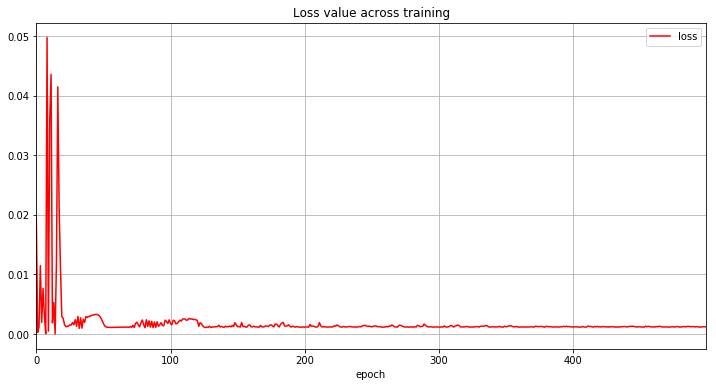

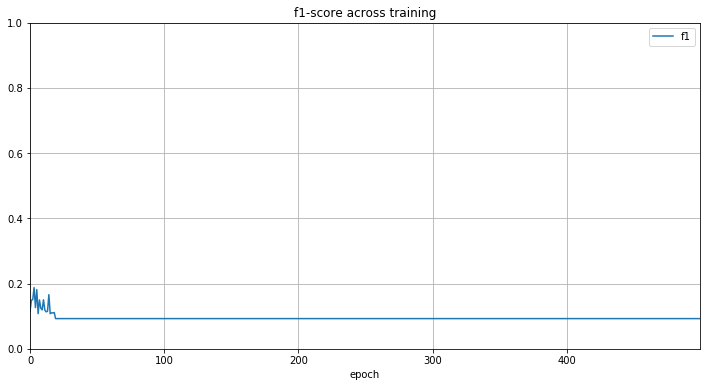

In [6]:
perf[perf['sent_idx'] == perf['sent_idx'].max()].plot(
    x='epoch', y='loss', c='red',
    grid=True,
    figsize=(12, 6),
    title='Loss value across training'
)
plt.show()

perf[perf['sent_idx'] == perf['sent_idx'].max()].plot(
    x='epoch', y='f1',
    grid=True,
    figsize=(12, 6),
    ylim=[0, 1],
    title='f1-score across training'
)
plt.show()

In [7]:
lead3 = ' '.join(sdf['sentence'][0:3])

finalsummary = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
baseline = rougeScores(ts_tokenized, Counter(lead3.split(" ")))

print("lead-3  recall = %.3f; precision = %.3f; f1-score = %.3f " % (baseline[0], baseline[1], baseline[2]))

print("learned recall = %.3f; precision = %.3f; f1-score = %.3f " % (finalsummary[0], finalsummary[1], finalsummary[2]))

lead-3  recall = 0.269; precision = 0.375; f1-score = 0.313 
learned recall = 0.049; precision = 0.833; f1-score = 0.093 


In [8]:
lead3

'b"editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events . here , soledad o\'brien takes users inside a jail where many of the inmates are mentally ill . an inmate housed on the `` forgotten floor , \'\' where many mentally ill inmates are housed in miami before trial .'

In [9]:
true_summary

'mentally ill inmates in miami are housed on the forgotten floor. judge steven leifman says most are there as a result of avoidable felonies. while cnn tours facility patient shouts i am the son of the president. leifman says the system is unjust and he fighting for change.'

In [10]:
curr_summary

' b"editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events . here , soledad o\'brien takes users inside a jail where many of the inmates are mentally ill . an inmate housed on the `` forgotten floor , \'\' where many mentally ill inmates are housed in miami before trial . miami , florida -lrb- cnn -rrb- -- the ninth floor of the miami-dade pretrial detention facility is dubbed the `` forgotten floor . \'\' here , inmates with the most severe mental illnesses are incarcerated until they \'re ready to appear in court . most often , they face drug charges or charges of assaulting an officer -- charges that judge steven leifman says are usually `` avoidable felonies . \'\' he says the arrests often result from confrontations with police . mentally ill people often wo n\'t do what they \'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become 